In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import pickle


In [2]:
data = pd.read_csv("/content/Telco-Customer-Churn.csv")
data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

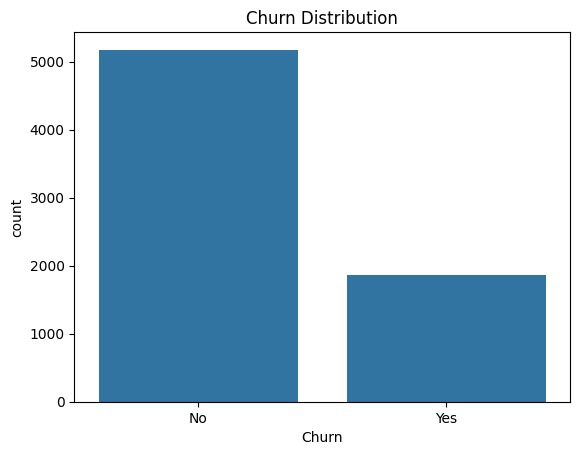

In [3]:
print(data.shape)
data.info()
data.describe()
sns.countplot(x="Churn", data=data)
plt.title("Churn Distribution")
plt.show()



In [5]:
# Separate numerical and categorical columns
num_cols = data.select_dtypes(include=["int64", "float64"]).columns
cat_cols = data.select_dtypes(include=["object"]).columns

# Impute numerical columns
num_imputer = SimpleImputer(strategy="median")
data[num_cols] = num_imputer.fit_transform(data[num_cols])

# Impute categorical columns
cat_imputer = SimpleImputer(strategy="most_frequent")
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])
label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


In [6]:
X = data.drop("Churn", axis=1)
y = data["Churn"]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [8]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [10]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train_res)

y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]


In [12]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train_res, y_train_res)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]


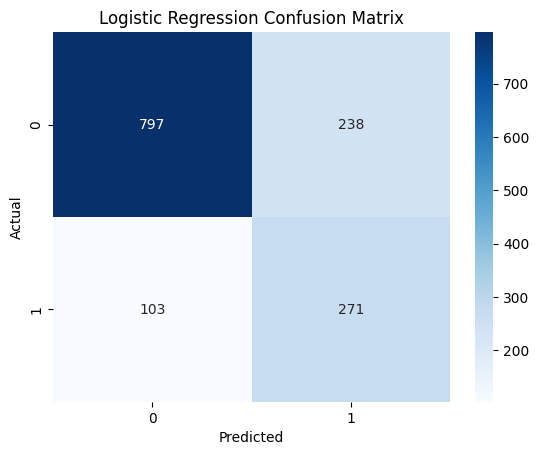

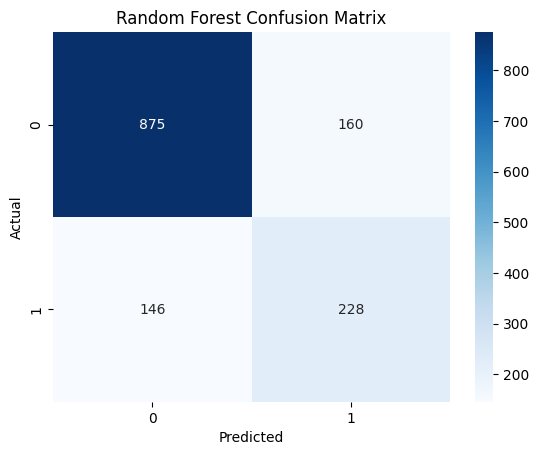

In [13]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")
plot_confusion(y_test, y_pred_rf, "Random Forest Confusion Matrix")


In [14]:
print("Logistic Regression Report:\n")
print(classification_report(y_test, y_pred_lr))

print("Random Forest Report:\n")
print(classification_report(y_test, y_pred_rf))


Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.89      0.77      0.82      1035
           1       0.53      0.72      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409

Random Forest Report:

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1035
           1       0.59      0.61      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.79      0.78      0.78      1409



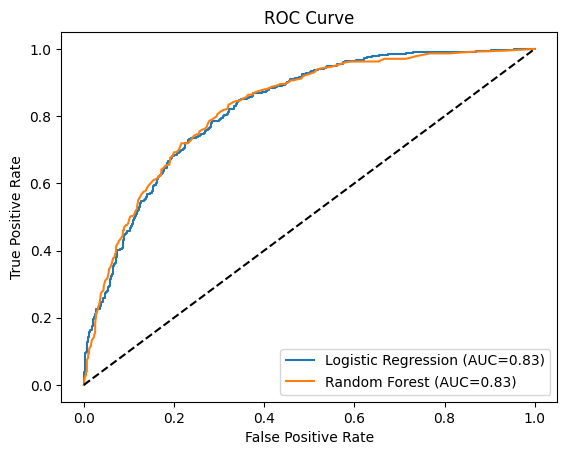

In [15]:
lr_auc = roc_auc_score(y_test, y_prob_lr)
rf_auc = roc_auc_score(y_test, y_prob_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC={lr_auc:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={rf_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


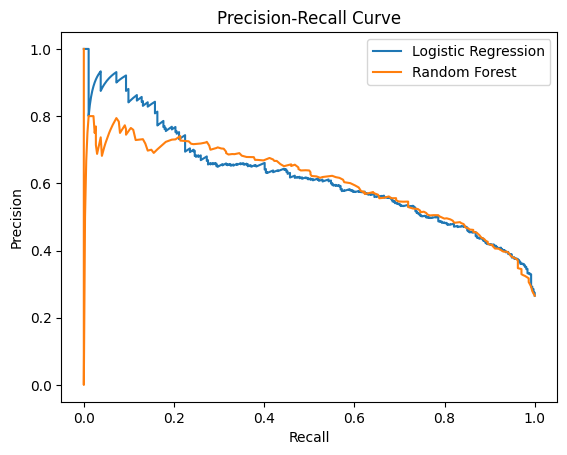

In [16]:
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)

plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_rf, precision_rf, label="Random Forest")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [17]:
with open("best_churn_model.pkl", "wb") as file:
    pickle.dump(rf_model, file)

print("Model saved successfully as best_churn_model.pkl")


Model saved successfully as best_churn_model.pkl
